In [1]:
import torch.nn as nn
import torch as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from random import randint, random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing

# Classes and methods creation

In [2]:
def MSEError(labels, predictions):
    return np.sum(np.diff([labels, predictions], axis=0)**2)/len(predictions)

def RMSEError(labels, predictions):
    return (MSEError(labels, predictions))**0.5

def MAEError(labels, predictions):
    return np.sum(abs(np.diff([labels, predictions], axis=0)))/len(predictions)

def MAPEError(labels, predictions):
    return np.sum(abs(np.divide(np.diff([labels, predictions], axis=0), labels)))/len(predictions)

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

def PolarPlotMaker(labels: list, values: list, primary_value_ref: str, polar_color:str, secundary_color: str, secundary_value_ref: str, polar_legend: str, secundary_values: pd.DataFrame=None, filename:str='Plot'):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    ax.plot(angles, values, color=polar_color, linewidth=1, label=primary_value_ref)
    ax.fill(angles, values, color=polar_color, alpha=0.25)

    ax.plot(angles, secundary_values, color=secundary_color, linewidth=1, label=secundary_value_ref)
    ax.fill(angles, secundary_values, color=secundary_color, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), labels)

    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    ax.set_rlabel_position(180 / num_vars)
    ax.set_title(polar_legend, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig(f'methodology/imgs/results/reports/comparing_error_{filename}.eps', dpi=600, bbox_inches='tight')
    plt.savefig(f'methodology/imgs/results/reports/comparing_error_{filename}.svg', dpi=600, bbox_inches='tight')
    plt.savefig(f'methodology/imgs/results/reports/comparing_error_{filename}.png', dpi=600, bbox_inches='tight')

    plt.show()

In [3]:
pecan_dataset = PecanParticipantPreProcessing('661_test_30_all', 'data/participants_data/1min/', 60)
default_scaler = pecan_dataset.get_scaler()

[!] - Trainable dataframe shape - (129086, 28)
[*] Train dataframe shape: (90360, 28)
[*] Validation dataframe shape: (25817, 28)
[*] Test dataframe shape: (12909, 28)


100%|█████████████████████████████████████████████████████████████████████████| 25757/25757 [00:01<00:00, 13181.63it/s]

[!] Train sequence shape: (60, 28)
[!] Val sequence shape: (60, 28)


In [4]:
all_data = pd.read_csv('etc/results/metrics/all_metrics.csv', sep=';')
all_data = all_data.sort_values(by=['model'])
all_data

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
2,0.003829,0.061882,0.034918,0.195160,0.902266,GRU
0,0.004249,0.065182,0.032485,0.203318,0.891565,LSTM
1,0.004124,0.064219,0.040503,0.225843,0.894746,RNN
3,0.006505,0.080653,0.049698,0.334738,0.833982,TST
4,0.035163,0.187519,0.162907,0.478139,0.102560,Transformer


In [5]:
pca_data = pd.read_csv('etc/results/metrics/pca_metrics.csv', sep=';')
pca_data = pca_data.sort_values(by=['model'])
pca_data



,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
2,0.003213,0.056681,0.029107,0.165222,0.918004,GRU
1,0.004104,0.064062,0.040248,0.207194,0.895259,LSTM
0,0.002855,0.053434,0.026051,0.161302,0.927130,RNN
3,0.007353,0.085752,0.050360,0.398466,0.812328,TST
4,0.037450,0.193519,0.168392,0.840950,0.044209,Transformer


['GRU', 'LSTM', 'RNN', 'TST', 'Transformer']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


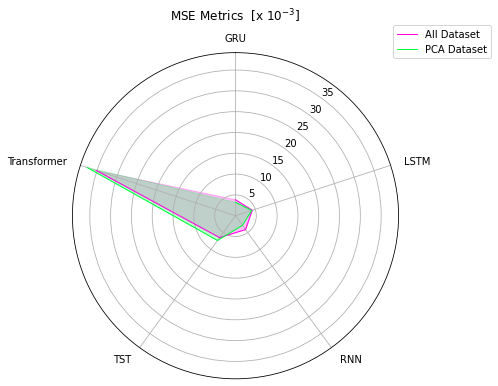

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


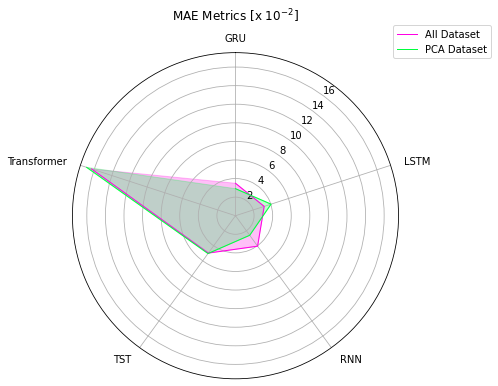

In [6]:
models_labels = all_data['model'].tolist()
print(models_labels)

MSE_Values = (all_data['calculate_MSE']* 1000).tolist() 
secundary_values = (pca_data['calculate_MSE']* 1000).tolist() 

PolarPlotMaker(labels=models_labels, values=MSE_Values, polar_color='#FF00E4', 
               primary_value_ref='All Dataset', secundary_value_ref='PCA Dataset',  
               secundary_color='#00FF3E', polar_legend=r"MSE Metrics  [x $10^{-3}$] ", secundary_values=secundary_values, filename = "MSE_Metrics")

MAE_Values = (all_data['calculate_MAE']*100).tolist() 
secundary_values = (pca_data['calculate_MAE']*100).tolist() 

PolarPlotMaker(labels=models_labels, values=MAE_Values, polar_color='#FF00E4', 
               primary_value_ref='All Dataset', secundary_value_ref='PCA Dataset',  
               secundary_color='#00FF3E', polar_legend=r"MAE Metrics [x $10^{-2}$] ", secundary_values=secundary_values, filename = "MaE_Metrics")


In [7]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = default_scaler.min_[-1], default_scaler.scale_[-1]

In [ ]:
descaled_sa_avg_ensemble_prediction = descale(descaler, sa_weight_avg)
descaled_avg_ensemble_prediction = descale(descaler, ensemble_predictions)
descaled_rnn_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'RNN'].model_output)
descaled_gru_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'GRU'].model_output)
descaled_lstm_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'LSTM'].model_output)
descaled_label = descale(descaler, labels)

# Results

In [ ]:
calc_result_df

In [ ]:
calc_result_df

# Previsões comparadas ao SA-Ensemble

In [ ]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_sa_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#B03A2E',label='SA-RecorrentEnsemble')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN')
plt.plot(descaled_gru_prediction[:60], '.', ms = 10, ls = '-', c = '#6C3483',label='GRU')
plt.plot(descaled_lstm_prediction[:60], '.', ms = 10, ls = '-', c = '#00FFB2',label='LSTM')



# plt.plot(output, 'm--', label='predictions')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.show()

# Comparativos entre Ensembles

In [ ]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_sa_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#B03A2E',label='SA-RecorrentEnsemble')
plt.plot(descaled_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#FF00E4',label='AVG RecorrentEnsemble - Prediction')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN - Prediction')

# plt.plot(output, 'm--', label='predictions')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.show()